# Variational Inference: Back to Basics

## The Problem We're Trying to Solve
Let's start with what we actually have and what we want to find:

## What We Have

- **Observed Data:** $x = [1.5, 2.0]$
- **A Model:** We assume this data comes from some probability distribution
- **Prior Beliefs:** We encode our initial beliefs about the parameters in a prior distribution

## What We Want

- We want to find the posterior distribution $p(\theta|x)$ that tells us:

   1. What parameters $\theta$ likely generated our data
   2. How uncertain we are about these parameters

## A Simple Example
Let's make this concrete with a simple generative process:

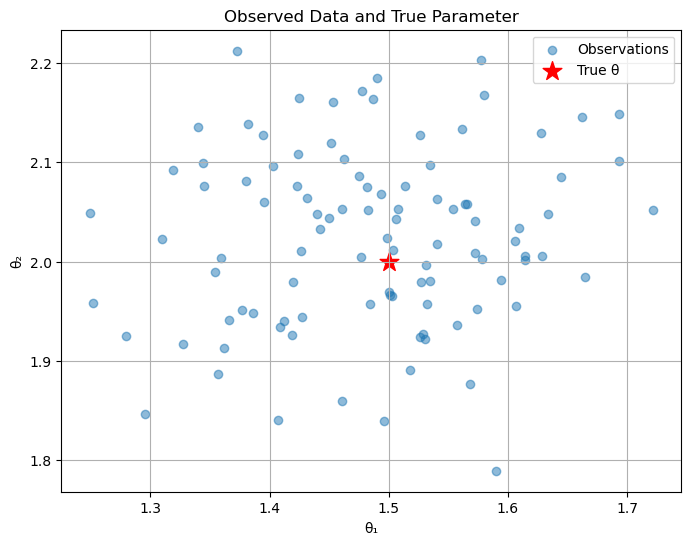

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# True parameter that generated the data
true_theta = torch.tensor([1.5, 2.0])

# Generate some observations with Gaussian noise
sigma_true = 0.1  # True noise level
n_samples = 100
observations = true_theta + sigma_true * torch.randn(n_samples, 2)

plt.figure(figsize=(8, 6))
plt.scatter(observations[:, 0], observations[:, 1], alpha=0.5, label='Observations')
plt.scatter([true_theta[0]], [true_theta[1]], color='red', marker='*', s=200, label='True θ')
plt.title('Observed Data and True Parameter')
plt.xlabel('θ₁')
plt.ylabel('θ₂')
plt.legend()
plt.grid(True)
plt.show()

## The Inference Problem

Now we have a more realistic scenario:

1. We have multiple observations
2. Each observation has some noise
3. We want to infer the underlying parameters that generated this data

**Our Model Assumptions**

- **Likelihood:** Each observation follows a Gaussian distribution around the true parameter
$$p(x|\theta) = \mathcal{N}(x; \theta, \sigma^2I)$$
- **Prior:** We assume a standard normal prior on $\theta$
$$p(\theta) = \mathcal{N}(\theta; 0, I)$$

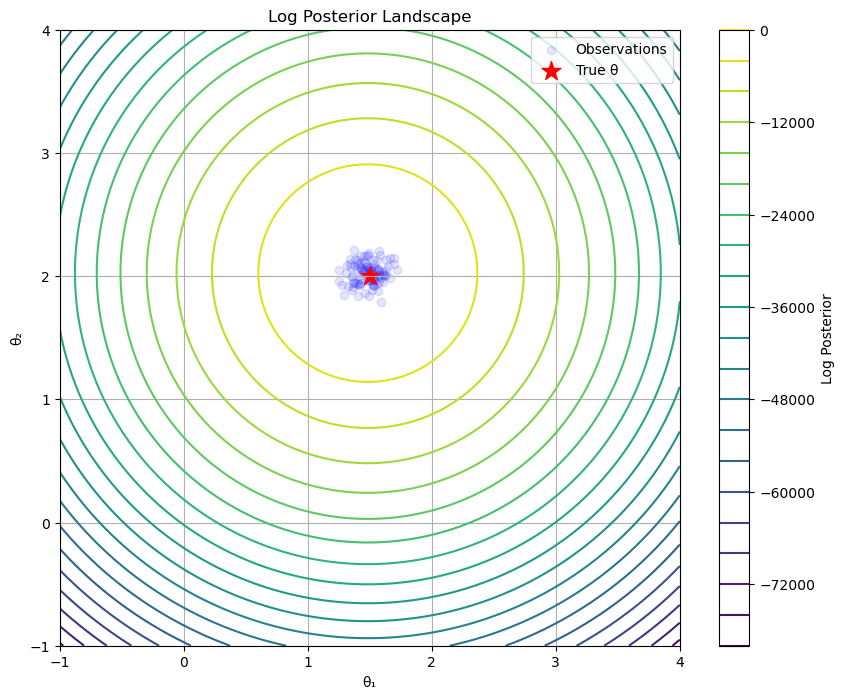

In [16]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Generate true data
true_theta = torch.tensor([1.5, 2.0])
sigma_true = 0.1
n_samples = 100
observations = true_theta + sigma_true * torch.randn(n_samples, 2)

def log_likelihood(theta, observations, sigma=0.1):
    """
    Log likelihood of all observations given parameters
    """
    # Broadcast theta to match observations shape
    theta_expanded = theta.view(1, 2)  # Shape: [1, 2]
    # observations has shape [n_samples, 2]
    return torch.sum(-0.5 * ((observations - theta_expanded)**2) / (sigma**2))

def log_prior(theta):
    """
    Log prior probability of parameters
    """
    return -0.5 * torch.sum(theta**2)

# Create grid for posterior landscape
theta1 = np.linspace(-1, 4, 100)
theta2 = np.linspace(-1, 4, 100)
T1, T2 = np.meshgrid(theta1, theta2)
log_posterior = np.zeros_like(T1)

# Compute log posterior for each point in the grid
for i in range(T1.shape[0]):
    for j in range(T1.shape[1]):
        theta = torch.tensor([T1[i,j], T2[i,j]])
        log_posterior[i,j] = (log_likelihood(theta, observations) + 
                            log_prior(theta)).detach().numpy()

# Plotting
plt.figure(figsize=(10, 8))
plt.contour(T1, T2, log_posterior, levels=20)
plt.colorbar(label='Log Posterior')
plt.scatter(observations[:, 0], observations[:, 1], 
           alpha=0.1, color='blue', label='Observations')
plt.scatter([true_theta[0]], [true_theta[1]], 
           color='red', marker='*', s=200, label='True θ')
plt.title('Log Posterior Landscape')
plt.xlabel('θ₁')
plt.ylabel('θ₂')
plt.legend()
plt.grid(True)
plt.show()



In [17]:
# Print some statistics
print(f"True parameters: {true_theta}")
print(f"Mean of observations: {torch.mean(observations, dim=0)}")
print(f"Std of observations: {torch.std(observations, dim=0)}")

True parameters: tensor([1.5000, 2.0000])
Mean of observations: tensor([1.4847, 2.0245])
Std of observations: tensor([0.1032, 0.0892])


## Why Variational Inference?

Now we can see what variational inference is actually doing:

1. The true posterior $p(\theta|x)$ (shown in the contour plot) is:

    - Computationally intractable for more complex models
    - Difficult to sample from directly


2. Variational inference approximates this posterior with a simpler distribution:

    - We choose a Gaussian approximation $q_{\phi}(\theta)$
    - We optimize its parameters (mean and variance) to make it close to the true posterior



Let's implement a simple version that shows what we're approximating:

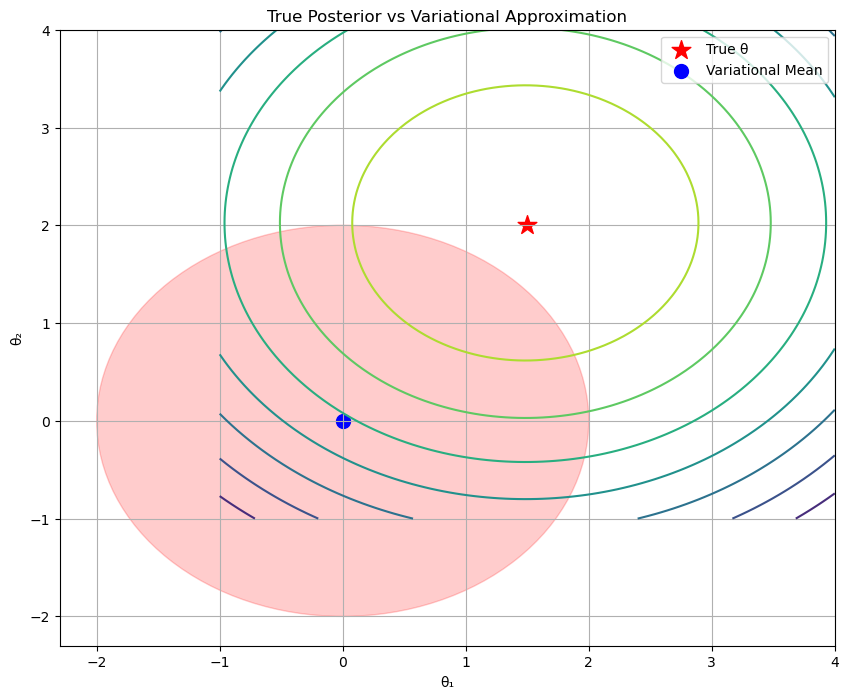

In [18]:
# Initialize variational parameters
mu = torch.zeros(2, requires_grad=True)
log_std = torch.zeros(2, requires_grad=True)

def plot_approximation(mu, log_std):
    """Plot true posterior and our approximation"""
    std = torch.exp(log_std)
    
    plt.figure(figsize=(10, 8))
    # Plot true posterior
    plt.contour(T1, T2, log_posterior)
    
    # Plot our approximation
    mean = mu.detach().numpy()
    std = std.detach().numpy()
    
    # Plot ellipse representing our approximation
    from matplotlib.patches import Ellipse
    ellip = Ellipse(xy=mean, width=4*std[0], height=4*std[1], 
                    angle=0, alpha=0.2, color='red')
    plt.gca().add_patch(ellip)
    
    plt.scatter([true_theta[0]], [true_theta[1]], color='red', marker='*', s=200, label='True θ')
    plt.scatter([mean[0]], [mean[1]], color='blue', marker='o', s=100, label='Variational Mean')
    plt.title('True Posterior vs Variational Approximation')
    plt.xlabel('θ₁')
    plt.ylabel('θ₂')
    plt.legend()
    plt.grid(True)
    plt.show()

# Show initial approximation
plot_approximation(mu, log_std)

### Implement the ELBO

The ELBO is defined as:

$$\text{ELBO}(\phi) = \mathbb{E}{q{\phi}(\theta)}[\log p(x|\theta) + \log p(\theta) - \log q_{\phi}(\theta)]$$

Breaking this down:



1. **Expected log likelihood:** $\mathbb{E}{q{\phi}}[\log p(x|\theta)] = \mathbb{E}{q{\phi}}[-\frac{1}{2\sigma^2}\sum_{i=1}^{n}(x_i-\theta)^T(x_i-\theta)]$
2. **Expected log prior:**
$\mathbb{E}{q{\phi}}[\log p(\theta)] = \mathbb{E}{q{\phi}}[-\frac{1}{2}\theta^T\theta]$
3. **Entropy of variational distribution:**
$-\mathbb{E}{q{\phi}}[\log q_{\phi}(\theta)] = \sum_{i=1}^d \log \sigma_i + \frac{d}{2}(1 + \log(2\pi))$


**Monte Carlo Estimation of ELBO**

We use the reparameterization trick to compute gradients:

$$\theta = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

Then our Monte Carlo estimate of the ELBO is:

$$\text{ELBO}(\phi) \approx \frac{1}{S}\sum_{s=1}^S [\log p(x|\theta^{(s)}) + \log p(\theta^{(s)}) - \log q_{\phi}(\theta^{(s)})]$$

where $\theta^{(s)} = \mu + \sigma \odot \epsilon^{(s)}$

In [19]:
def compute_elbo(mu, log_std, observations, n_samples=10):
    """
    Compute ELBO using Monte Carlo sampling
    """
    std = torch.exp(log_std)
    
    # Sample from variational distribution using reparameterization trick
    epsilon = torch.randn(n_samples, 2)  # n_samples from N(0,1)
    theta_samples = mu + std * epsilon   # Reparameterization trick
    
    # Compute log probabilities for each sample
    log_p_x = torch.stack([log_likelihood(theta, observations) for theta in theta_samples])
    log_p_theta = torch.stack([log_prior(theta) for theta in theta_samples])
    
    # Compute log q(theta) for each sample
    log_q = -0.5 * torch.sum(((theta_samples - mu) / std)**2, dim=1) \
            - torch.sum(log_std) \
            - len(mu) * 0.5 * torch.log(2 * torch.tensor(np.pi))
    
    # ELBO = E_q[log p(x|θ) + log p(θ) - log q(θ)]
    elbo = torch.mean(log_p_x + log_p_theta - log_q)
    
    return elbo

### Then, implement the optimization loop:

We maximize the ELBO using gradient ascent:

$$\phi_{t+1} = \phi_t + \alpha \nabla_{\phi}\text{ELBO}(\phi_t)$$

In practice, using Adam optimizer:

$$m_t = \beta_1 m_{t-1} + (1-\beta_1)\nabla_{\phi}\text{ELBO}(\phi_t)$$
$$v_t = \beta_2 v_{t-1} + (1-\beta_2)(\nabla_{\phi}\text{ELBO}(\phi_t))^2$$
$$\phi_{t+1} = \phi_t + \alpha \frac{m_t}{\sqrt{v_t} + \epsilon}$$

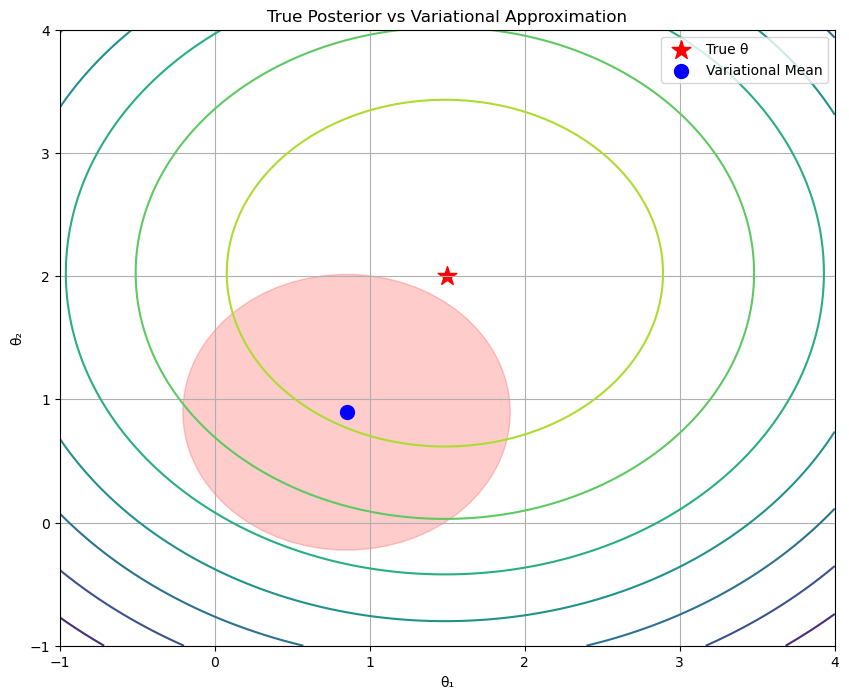

Iteration 100, ELBO: -9580.12


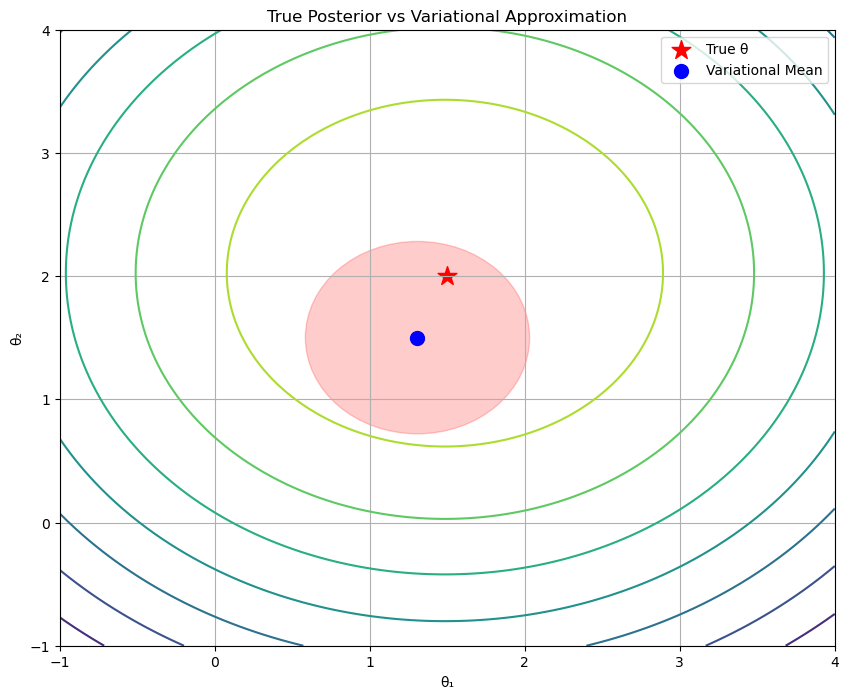

Iteration 200, ELBO: -3458.95


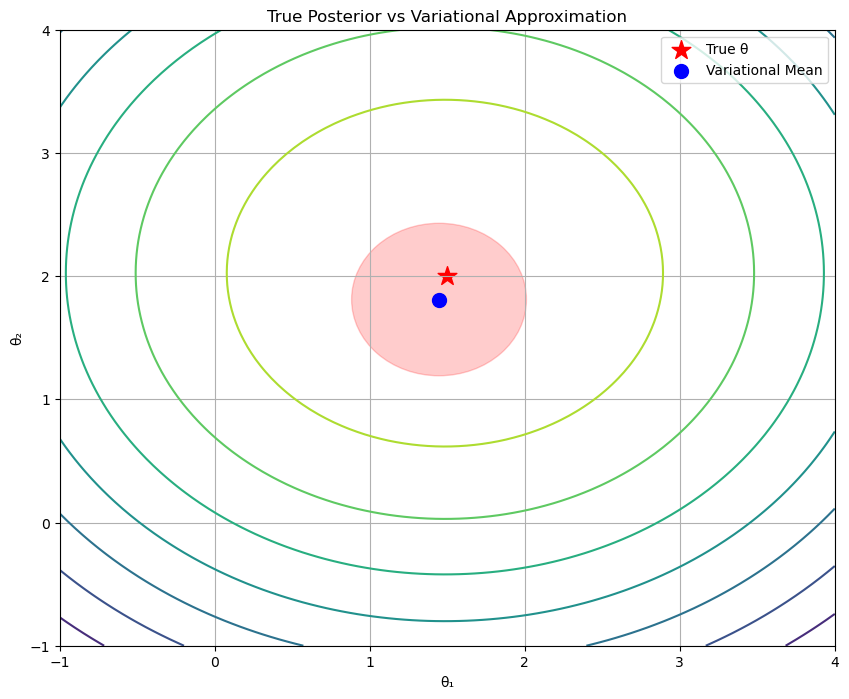

Iteration 300, ELBO: -1537.05


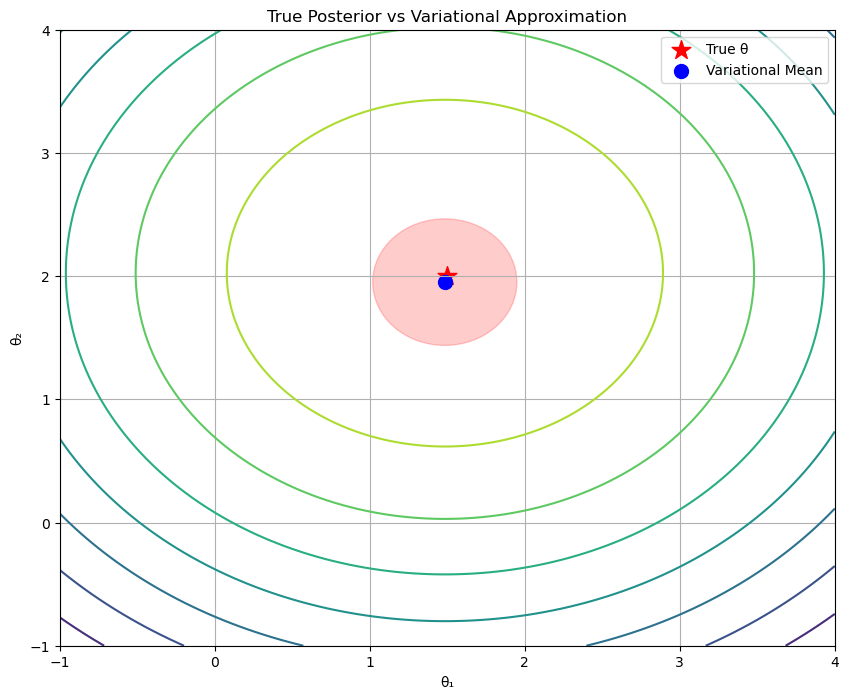

Iteration 400, ELBO: -963.77


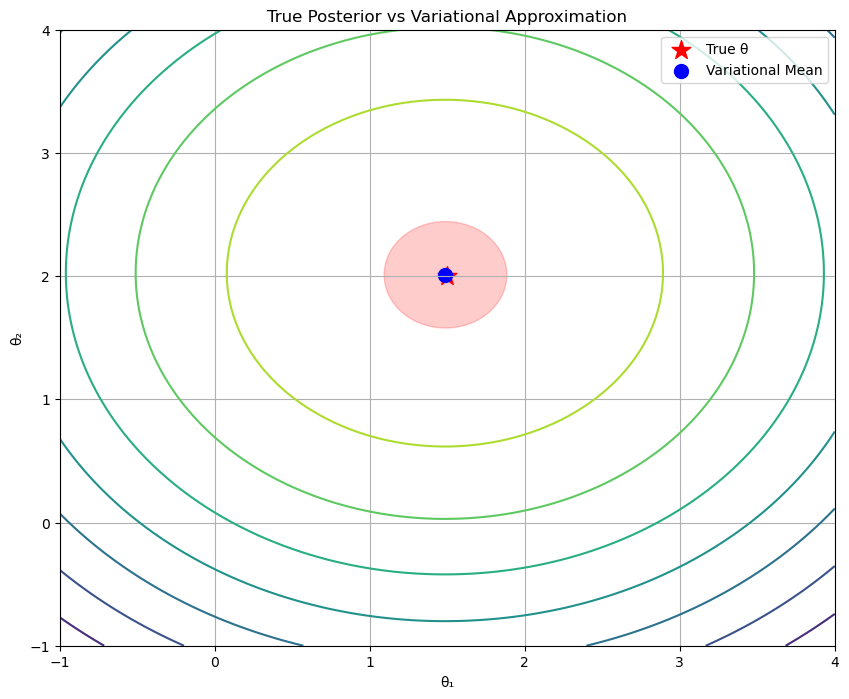

Iteration 500, ELBO: -521.50


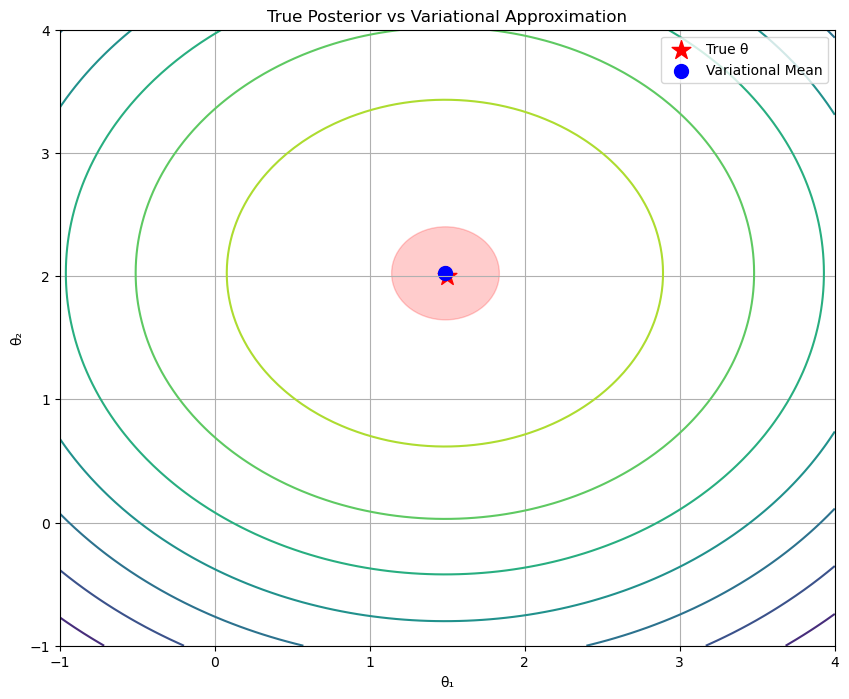

Iteration 600, ELBO: -641.40


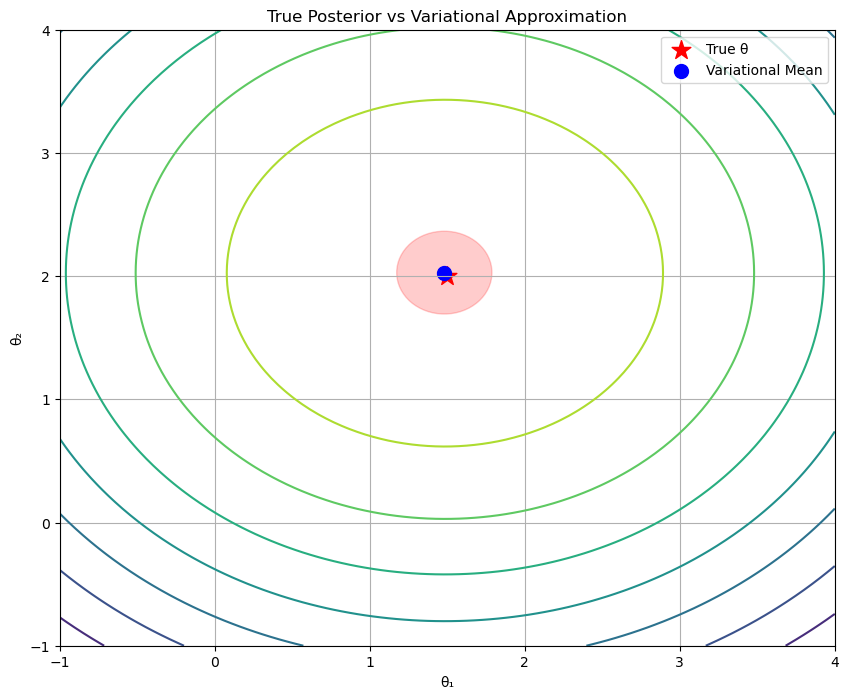

Iteration 700, ELBO: -459.68


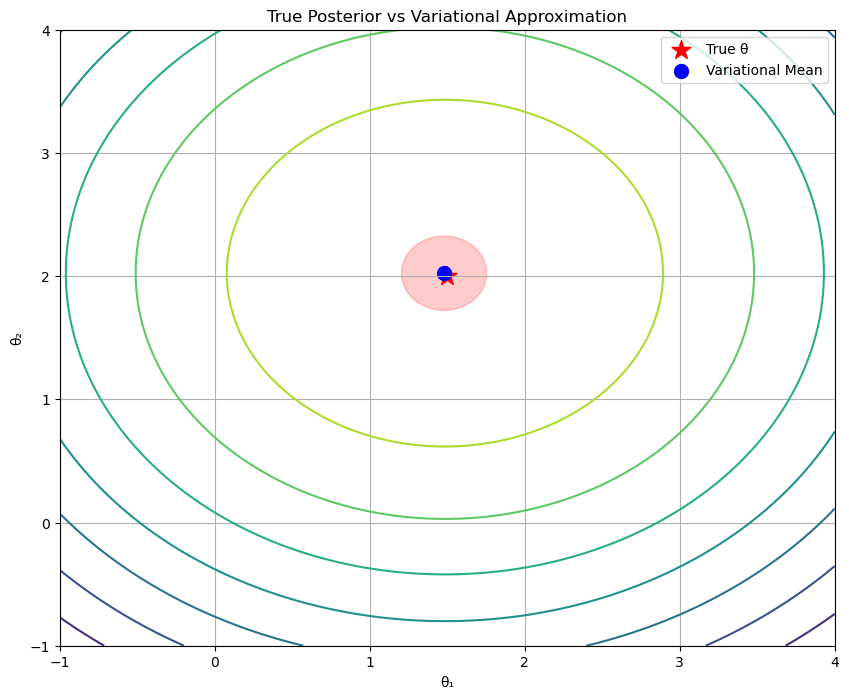

Iteration 800, ELBO: -393.39


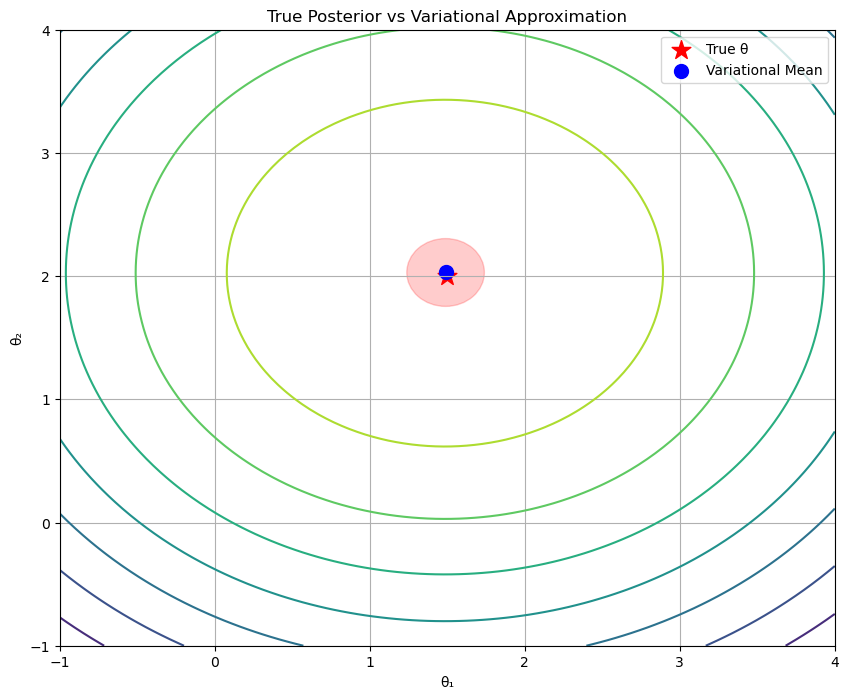

Iteration 900, ELBO: -244.31


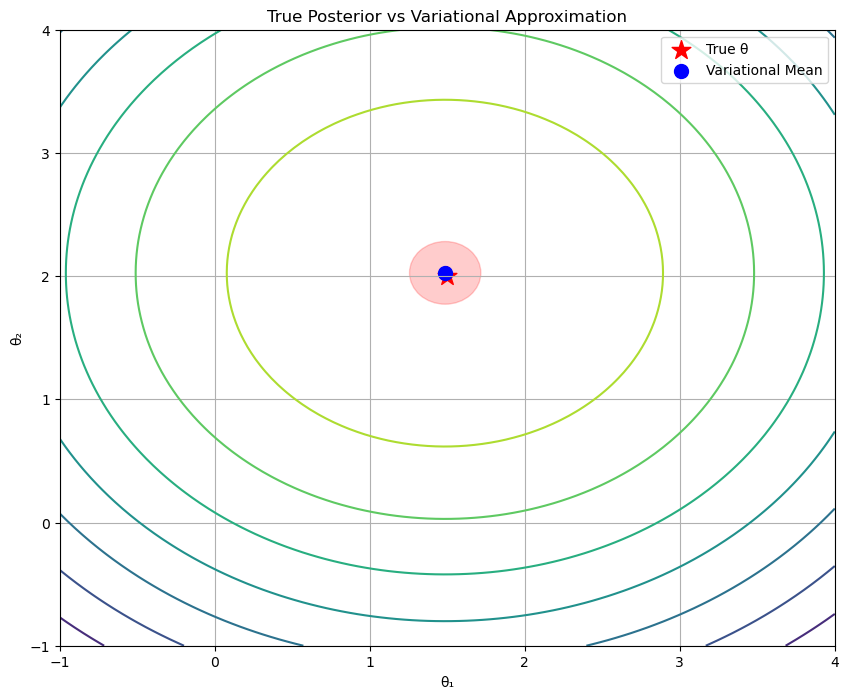

Iteration 1000, ELBO: -232.45


In [11]:
# Setup optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam([mu, log_std], lr=learning_rate)

# Storage for tracking progress
elbo_history = []
mu_history = []
std_history = []

# Optimization loop
n_iterations = 1000
for t in range(n_iterations):
    optimizer.zero_grad()
    
    # Compute ELBO
    elbo = compute_elbo(mu, log_std, observations)
    
    # Maximize ELBO (minimize -ELBO)
    loss = -elbo
    loss.backward()
    optimizer.step()
    
    # Store values for visualization
    elbo_history.append(elbo.item())
    mu_history.append(mu.detach().numpy())
    std_history.append(torch.exp(log_std).detach().numpy())
    
    # Plot progress every 100 iterations
    if (t + 1) % 100 == 0:
        plot_approximation(mu, log_std)
        print(f'Iteration {t+1}, ELBO: {elbo.item():.2f}')

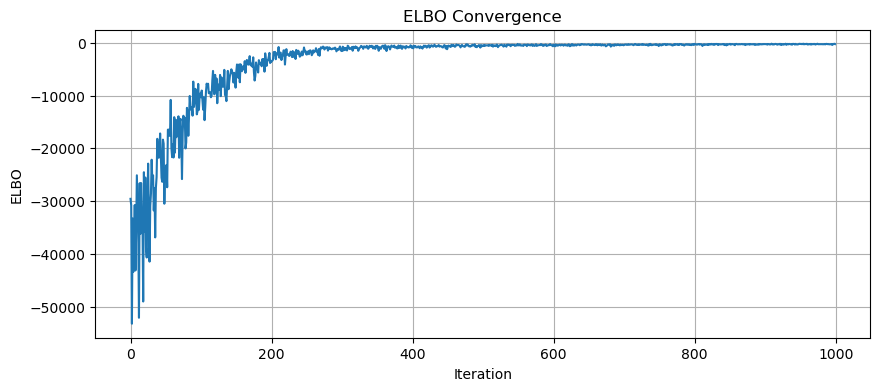

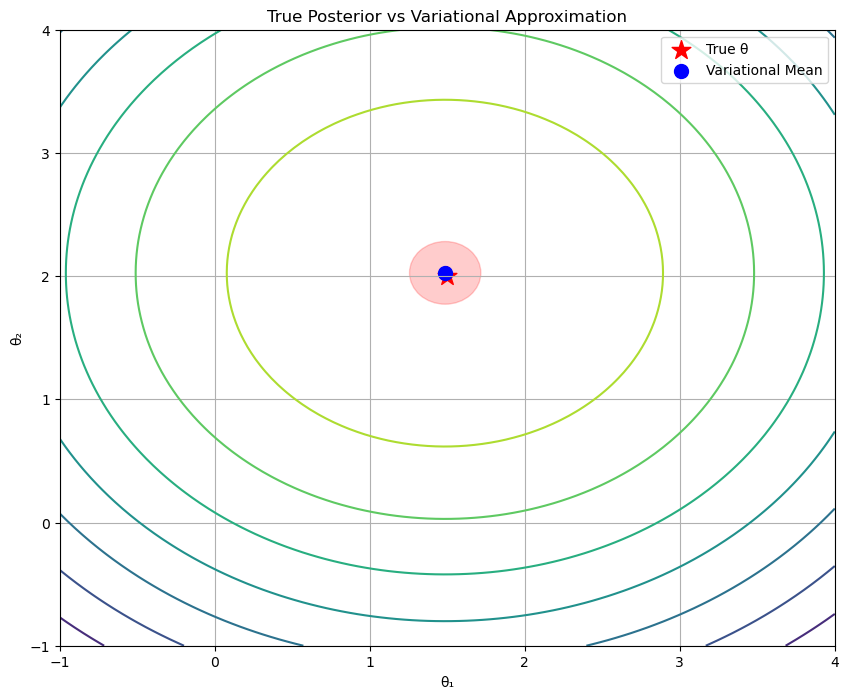


Final Results:
True parameters: tensor([1.5000, 2.0000])
Estimated mean: tensor([1.4865, 2.0265])
Estimated std: tensor([0.1150, 0.1271])


In [12]:
# Plot ELBO convergence
plt.figure(figsize=(10, 4))
plt.plot(elbo_history)
plt.title('ELBO Convergence')
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.grid(True)
plt.show()

# Plot final approximation
plot_approximation(mu, log_std)
print("\nFinal Results:")
print(f"True parameters: {true_theta}")
print(f"Estimated mean: {mu.detach()}")
print(f"Estimated std: {torch.exp(log_std).detach()}")